In [ ]:
# BLOCK 1: Imports and Setup
print("STARTING SOUND CLASSIFICATION ML PIPELINE")
print("=" * 60)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import warnings
warnings.filterwarnings('ignore')

sys.path.append('./src')

print("All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Librosa version: {librosa.__version__}")

# Configuration
CLASS_NAMES = [
    'air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 
    'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 
    'siren', 'street_music'
]

DATA_DIR = './data'
MODEL_SAVE_PATH = './models/sound_classifier.pkl'

print(f"CONFIGURATION:")
print(f"Classes: {CLASS_NAMES}")
print(f"Data Directory: {DATA_DIR}")
print(f"Model Save Path: {MODEL_SAVE_PATH}")

# Create directories
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs('./models', exist_ok=True)
os.makedirs('./src', exist_ok=True)
os.makedirs('./api', exist_ok=True)
os.makedirs('./ui', exist_ok=True)
os.makedirs('./load_test', exist_ok=True)

print("Project directories created!")

STARTING SOUND CLASSIFICATION ML PIPELINE
All libraries imported successfully!
NumPy version: 2.3.5
Librosa version: 0.11.0
CONFIGURATION:
Classes: ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
Data Directory: ./data
Model Save Path: ./models/sound_classifier.pkl
Project directories created!


In [ ]:
# BLOCK 2: Data Acquisition
print("\n" + "=" * 60)
print("DATA ACQUISITION - CREATING URBANSOUND8K-LIKE DATASET")
print("=" * 60)

def create_urbansound_like_dataset():
    print("Generating synthetic audio dataset...")

    urban_sound_dir = os.path.join(DATA_DIR, 'UrbanSound8K', 'audio')
    os.makedirs(urban_sound_dir, exist_ok=True)
    
    for fold in range(1, 6):  
        fold_path = os.path.join(urban_sound_dir, f'fold{fold}')
        os.makedirs(fold_path, exist_ok=True)
    
    audio_files = []
    labels = []
    file_count = 0
    
    for class_id, class_name in enumerate(CLASS_NAMES):
        print(f"   Creating {class_name} samples...")

        for i in range(12):
            fold_num = (file_count % 5) + 1  
            duration = 2.0 + np.random.random() * 1.0  
            sr = 22050
            t = np.linspace(0, duration, int(sr * duration))

            if class_name == 'air_conditioner':
                audio = 0.3 * np.sin(2 * np.pi * 200 * t)
            elif class_name == 'car_horn':
                envelope = np.ones_like(t)
                attack = int(0.1 * len(t))
                release = int(0.2 * len(t))
                envelope[:attack] = np.linspace(0, 1, attack)
                envelope[-release:] = np.linspace(1, 0, release)
                audio = 0.6 * envelope * np.sin(2 * np.pi * 800 * t)
            elif class_name == 'dog_bark':
                envelope = np.zeros_like(t)
                start = len(t) // 3
                end = start + len(t) // 6
                envelope[start:end] = np.hanning(end - start)
                audio = 0.5 * envelope * np.sin(2 * np.pi * 1000 * t)
            elif class_name == 'drilling':
                rhythm = (np.sin(2 * np.pi * 8 * t) > 0).astype(float)
                audio = 0.4 * rhythm * np.sin(2 * np.pi * 300 * t)
            elif class_name == 'engine_idling':
                audio = 0.25 * np.sin(2 * np.pi * 150 * t)
            elif class_name == 'gun_shot':
                envelope = np.exp(-8 * t)
                audio = 0.7 * envelope * np.sin(2 * np.pi * 500 * t)
            elif class_name == 'jackhammer':
                rhythm = (np.sin(2 * np.pi * 15 * t) > 0).astype(float)
                audio = 0.45 * rhythm * np.sin(2 * np.pi * 250 * t)
            elif class_name == 'siren':
                freq_sweep = 600 * (1 + 0.4 * np.sin(2 * np.pi * 0.3 * t))
                audio = 0.35 * np.sin(2 * np.pi * freq_sweep * t)
            elif class_name == 'street_music':
                audio = 0.2 * (np.sin(2 * np.pi * 440 * t) + 
                              0.6 * np.sin(2 * np.pi * 554 * t) +
                              0.4 * np.sin(2 * np.pi * 659 * t))
            else:  # children_playing
                audio = 0.3 * np.sin(2 * np.pi * 700 * t)
            
            audio += 0.05 * np.random.normal(0, 1, len(audio))
            audio = audio / (np.max(np.abs(audio)) + 1e-8)
            
            file_id = file_count + 1000
            start_time = 0
            end_time = int(duration * 1000)
            filename = f"{file_id}-{class_id}-{start_time}-{end_time}-1.wav"
            
            fold_path = os.path.join(urban_sound_dir, f'fold{fold_num}')
            filepath = os.path.join(fold_path, filename)
           
            import soundfile as sf
            sf.write(filepath, audio, sr)
            
            audio_files.append(filepath)
            labels.append(class_id)
            file_count += 1
    
    print(f"Created UrbanSound8K-like dataset with {len(audio_files)} files")
    return audio_files, labels

audio_files, labels = create_urbansound_like_dataset()

print(f"DATASET SUMMARY:")
print(f"   Total audio files: {len(audio_files)}")
print(f"   Total labels: {len(labels)}")
print(f"   Number of classes: {len(CLASS_NAMES)}")
print(f"   Files per class: {len(audio_files) // len(CLASS_NAMES)}")

if audio_files:
    print(f"   Sample file: {os.path.basename(audio_files[0])}")
    print(f"   Sample label: {labels[0]} -> {CLASS_NAMES[labels[0]]}")


DATA ACQUISITION - CREATING URBANSOUND8K-LIKE DATASET
Generating synthetic audio dataset...
   Creating air_conditioner samples...
   Creating car_horn samples...
   Creating children_playing samples...
   Creating dog_bark samples...
   Creating drilling samples...
   Creating engine_idling samples...
   Creating gun_shot samples...
   Creating jackhammer samples...
   Creating siren samples...
   Creating street_music samples...
Created UrbanSound8K-like dataset with 120 files
DATASET SUMMARY:
   Total audio files: 120
   Total labels: 120
   Number of classes: 10
   Files per class: 12
   Sample file: 1000-0-0-2943-1.wav
   Sample label: 0 -> air_conditioner


In [ ]:
# BLOCK 3: Data Processing 
print("\n" + "=" * 60)
print("DATA PROCESSING - FEATURE EXTRACTION")
print("=" * 60)

class AudioPreprocessor:
    def __init__(self, sr=22050, n_mfcc=40, max_len=174):
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.max_len = max_len
        print(f"Preprocessor initialized:")
        print(f"   - Sample Rate: {self.sr}Hz")
        print(f"   - MFCC Coefficients: {self.n_mfcc}")
        print(f"   - Max Length: {self.max_len} frames")
        print(f"   - Feature Vector Size: {self.n_mfcc * self.max_len}")
    
    def extract_features(self, file_path):
        try:
            audio, sr = librosa.load(file_path, sr=self.sr)
            
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=self.n_mfcc)

            if mfccs.shape[1] < self.max_len:
                pad_width = self.max_len - mfccs.shape[1]
                mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
            else:
                mfccs = mfccs[:, :self.max_len]
            
            return mfccs.flatten()
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            return None
    
    def batch_process(self, audio_files, labels):
        features = []
        valid_labels = []
        valid_files = []
        
        print("Processing audio files...")
        for i, (file_path, label) in enumerate(zip(audio_files, labels)):
            if i % 20 == 0:
                print(f"   Processed {i}/{len(audio_files)} files...")
            
            feature = self.extract_features(file_path)
            if feature is not None:
                features.append(feature)
                valid_labels.append(label)
                valid_files.append(file_path)
        
        return np.array(features), np.array(valid_labels), valid_files

preprocessor = AudioPreprocessor()

X, y, successful_files = preprocessor.batch_process(audio_files, labels)

print(f"FEATURE EXTRACTION COMPLETED!")
print(f"   Features matrix shape: {X.shape}")
print(f"   Labels shape: {y.shape}")
print(f"   Successfully processed: {len(successful_files)}/{len(audio_files)} files")
print(f"   Feature vector size: {X.shape[1]}")

preprocessor_path = './models/audio_preprocessor.pkl'
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor saved to: {preprocessor_path}")


DATA PROCESSING - FEATURE EXTRACTION
Preprocessor initialized:
   - Sample Rate: 22050Hz
   - MFCC Coefficients: 40
   - Max Length: 174 frames
   - Feature Vector Size: 6960
Processing audio files...
   Processed 0/120 files...
   Processed 20/120 files...
   Processed 40/120 files...
   Processed 60/120 files...
   Processed 80/120 files...
   Processed 100/120 files...
FEATURE EXTRACTION COMPLETED!
   Features matrix shape: (120, 6960)
   Labels shape: (120,)
   Successfully processed: 120/120 files
   Feature vector size: 6960
Preprocessor saved to: ./models/audio_preprocessor.pkl



DATA VISUALIZATION & ANALYSIS
Working with 120 samples and 6960 features
CLASS DISTRIBUTION ANALYSIS


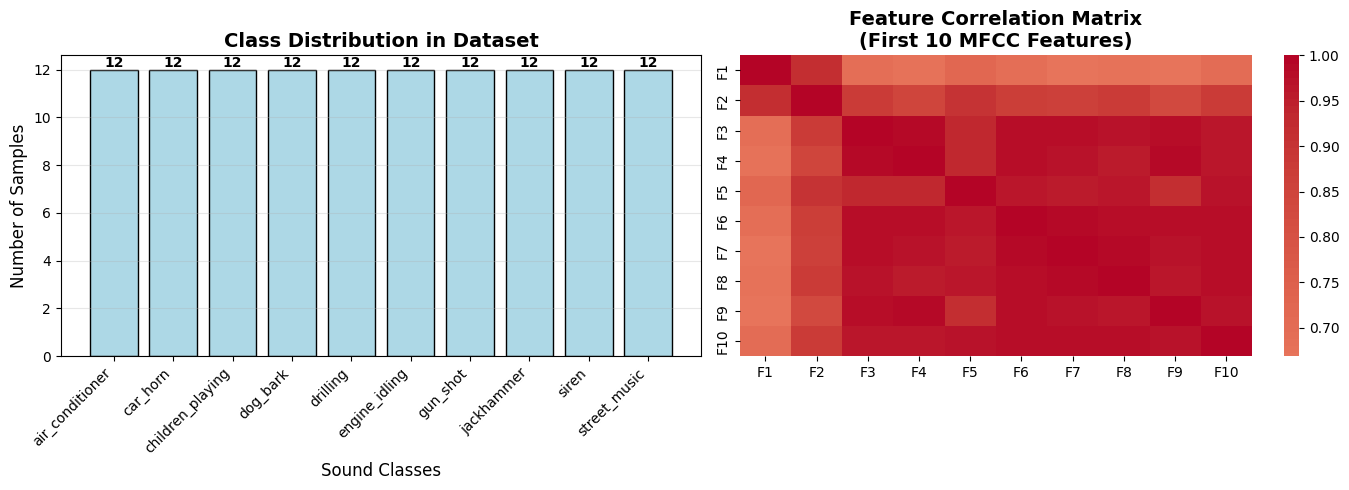

CLASS DISTRIBUTION:
   air_conditioner     :  12 samples
   car_horn            :  12 samples
   children_playing    :  12 samples
   dog_bark            :  12 samples
   drilling            :  12 samples
   engine_idling       :  12 samples
   gun_shot            :  12 samples
   jackhammer          :  12 samples
   siren               :  12 samples
   street_music        :  12 samples
FEATURE STATISTICS:
   Mean of all features: -0.3986
   Standard deviation: 8.0867
   Minimum value: -109.1233
   Maximum value: 79.9342
   Feature matrix size: 120 samples x 6960 features


In [ ]:
# BLOCK 4: Data Visualization & Analysis
print("\n" + "=" * 60)
print("DATA VISUALIZATION & ANALYSIS")
print("=" * 60)

print(f"Working with {X.shape[0]} samples and {X.shape[1]} features")

print("CLASS DISTRIBUTION ANALYSIS")
class_counts = [np.sum(y == i) for i in range(len(CLASS_NAMES))]

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
bars = plt.bar(CLASS_NAMES, class_counts, color='lightblue', edgecolor='black')
plt.title('Class Distribution in Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Sound Classes', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 2, 2)
feature_corr = np.corrcoef(X[:, :10].T)
sns.heatmap(feature_corr, annot=False, cmap='coolwarm', center=0,
            xticklabels=[f'F{i+1}' for i in range(10)],
            yticklabels=[f'F{i+1}' for i in range(10)])
plt.title('Feature Correlation Matrix\n(First 10 MFCC Features)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("CLASS DISTRIBUTION:")
for i, (class_name, count) in enumerate(zip(CLASS_NAMES, class_counts)):
    print(f"   {class_name:20s}: {count:3d} samples")

print("FEATURE STATISTICS:")
print(f"   Mean of all features: {np.mean(X):.4f}")
print(f"   Standard deviation: {np.std(X):.4f}")
print(f"   Minimum value: {np.min(X):.4f}")
print(f"   Maximum value: {np.max(X):.4f}")
print(f"   Feature matrix size: {X.shape[0]} samples x {X.shape[1]} features")

In [ ]:
# BLOCK 5: Model Creation & Training
print("\n" + "=" * 60)
print("MODEL CREATION & TRAINING")
print("=" * 60)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Dataset Split:")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")
print(f"   Features per sample: {X_train.shape[1]}")

print("Training Random Forest Classifier...")

model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2
)

import time
start_time = time.time()

model.fit(X_train, y_train)

training_time = time.time() - start_time

train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

print(f"Model training completed!")
print(f"Training time: {training_time:.2f} seconds")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

feature_importance = model.feature_importances_
top_10_features = np.argsort(feature_importance)[-10:][::-1]

print(f"TOP 10 MOST IMPORTANT FEATURES:")
for i, idx in enumerate(top_10_features[:10]):
    print(f"   {i+1:2d}. Feature {idx:4d}: {feature_importance[idx]:.6f}")

joblib.dump(model, MODEL_SAVE_PATH)
print(f"Model saved to: {MODEL_SAVE_PATH}")


MODEL CREATION & TRAINING
Dataset Split:
   Training set: 96 samples
   Test set: 24 samples
   Features per sample: 6960
Training Random Forest Classifier...
Model training completed!
Training time: 0.43 seconds
Training Accuracy: 1.0000
Test Accuracy: 1.0000
TOP 10 MOST IMPORTANT FEATURES:
    1. Feature 3848: 0.005261
    2. Feature  182: 0.004393
    3. Feature  251: 0.003858
    4. Feature   82: 0.003745
    5. Feature 4709: 0.003685
    6. Feature   74: 0.003600
    7. Feature 1262: 0.003589
    8. Feature 6348: 0.003577
    9. Feature  192: 0.003542
   10. Feature  218: 0.003475
Model saved to: ./models/sound_classifier.pkl



MODEL TESTING & EVALUATION
DETAILED PERFORMANCE METRICS:
   Accuracy: 1.0000
   Precision (macro): 1.0000
   Recall (macro): 1.0000
   F1-Score (macro): 1.0000


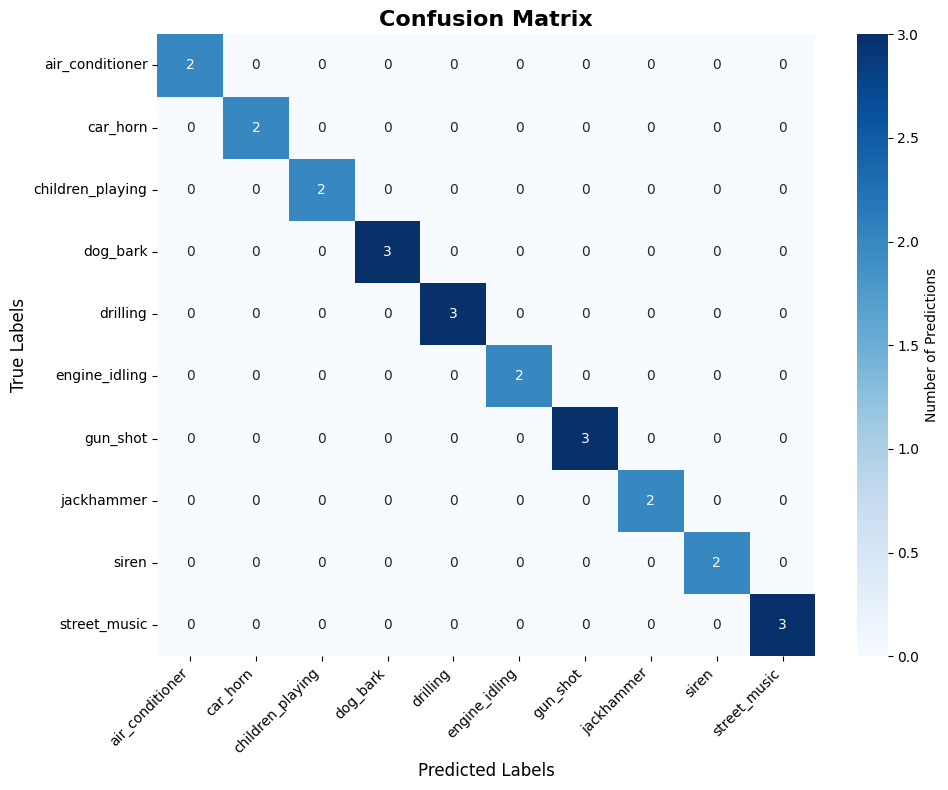

PER-CLASS PERFORMANCE METRICS:
           Class  Precision  Recall  F1-Score  Support
 air_conditioner        1.0     1.0       1.0      2.0
        car_horn        1.0     1.0       1.0      2.0
children_playing        1.0     1.0       1.0      2.0
        dog_bark        1.0     1.0       1.0      3.0
        drilling        1.0     1.0       1.0      3.0
   engine_idling        1.0     1.0       1.0      2.0
        gun_shot        1.0     1.0       1.0      3.0
      jackhammer        1.0     1.0       1.0      2.0
           siren        1.0     1.0       1.0      2.0
    street_music        1.0     1.0       1.0      3.0


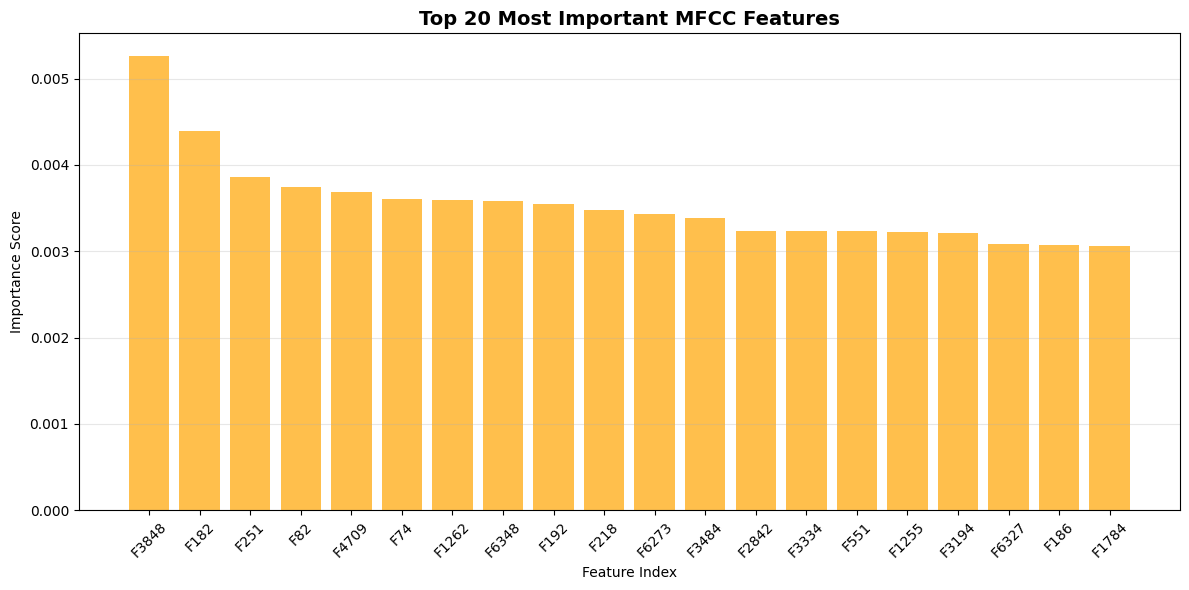

MODEL EVALUATION SUMMARY:
   Model achieved 1.0000 accuracy on test set
   24 out of 24 test samples correctly classified


In [ ]:
# BLOCK 6: Model Testing & Evaluation
print("\n" + "=" * 60)
print("MODEL TESTING & EVALUATION")
print("=" * 60)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=CLASS_NAMES, output_dict=True)
cm = confusion_matrix(y_test, y_pred)

print(f"DETAILED PERFORMANCE METRICS:")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   Precision (macro): {report['macro avg']['precision']:.4f}")
print(f"   Recall (macro): {report['macro avg']['recall']:.4f}")
print(f"   F1-Score (macro): {report['macro avg']['f1-score']:.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Number of Predictions'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("PER-CLASS PERFORMANCE METRICS:")
class_metrics = []
for class_name in CLASS_NAMES:
    if class_name in report:
        class_metrics.append({
            'Class': class_name,
            'Precision': report[class_name]['precision'],
            'Recall': report[class_name]['recall'],
            'F1-Score': report[class_name]['f1-score'],
            'Support': report[class_name]['support']
        })

metrics_df = pd.DataFrame(class_metrics)
print(metrics_df.to_string(index=False))


plt.figure(figsize=(12, 6))
top_20_indices = np.argsort(feature_importance)[-20:][::-1]
top_20_importances = feature_importance[top_20_indices]

plt.bar(range(20), top_20_importances, color='orange', alpha=0.7)
plt.title('Top 20 Most Important MFCC Features', fontsize=14, fontweight='bold')
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.xticks(range(20), [f'F{idx}' for idx in top_20_indices], rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"MODEL EVALUATION SUMMARY:")
print(f"   Model achieved {accuracy:.4f} accuracy on test set")
print(f"   {np.sum(y_pred == y_test)} out of {len(y_test)} test samples correctly classified")

In [ ]:
# BLOCK 7: Model Prediction Functions
print("\n" + "=" * 60)
print("MODEL PREDICTION FUNCTIONS")
print("=" * 60)

class SoundPredictor:
    def __init__(self, model_path, preprocessor_path):
        self.model = joblib.load(model_path)
        self.preprocessor = joblib.load(preprocessor_path)
        self.class_names = CLASS_NAMES
        print("SoundPredictor initialized!")
    
    def predict_audio_file(self, audio_path):
        try:
            features = self.preprocessor.extract_features(audio_path)
            if features is None:
                return None
            
            features = features.reshape(1, -1)
            prediction = self.model.predict(features)[0]
            probabilities = self.model.predict_proba(features)[0]
            
            return {
                'filename': os.path.basename(audio_path),
                'predicted_class': self.class_names[prediction],
                'confidence': float(probabilities[prediction]),
                'all_probabilities': {
                    self.class_names[i]: float(prob) 
                    for i, prob in enumerate(probabilities)
                },
                'features_used': features.shape[1]
            }
        except Exception as e:
            print(f"Prediction error: {e}")
            return None
    
    def predict_batch(self, audio_files):
        results = []
        for audio_file in audio_files:
            result = self.predict_audio_file(audio_file)
            if result:
                results.append(result)
        return results
    
    def get_model_info(self):
        return {
            'model_type': type(self.model).__name__,
            'classes': self.class_names,
            'num_classes': len(self.class_names),
            'feature_size': self.preprocessor.n_mfcc * self.preprocessor.max_len
        }


predictor = SoundPredictor(MODEL_SAVE_PATH, './models/audio_preprocessor.pkl')

print("TESTING PREDICTIONS:")
test_files = audio_files[:3]  # Test on first 3 files
for i, test_file in enumerate(test_files):
    result = predictor.predict_audio_file(test_file)
    if result:
        true_class = CLASS_NAMES[labels[i]]
        print(f"File: {result['filename']}")
        print(f"   True Class: {true_class}")
        print(f"   Predicted: {result['predicted_class']}")
        print(f"   Confidence: {result['confidence']:.4f}")
        print(f"   Correct: {true_class == result['predicted_class']}")
        
        sorted_probs = sorted(result['all_probabilities'].items(), 
                            key=lambda x: x[1], reverse=True)[:3]
        print(f"   Top 3 predictions:")
        for class_name, prob in sorted_probs:
            print(f"      - {class_name}: {prob:.4f}")

model_info = predictor.get_model_info()
print(f"MODEL INFORMATION:")
print(f"   Model Type: {model_info['model_type']}")
print(f"   Number of Classes: {model_info['num_classes']}")
print(f"   Feature Vector Size: {model_info['feature_size']}")


MODEL PREDICTION FUNCTIONS
SoundPredictor initialized!
TESTING PREDICTIONS:
File: 1000-0-0-2943-1.wav
   True Class: air_conditioner
   Predicted: air_conditioner
   Confidence: 0.9300
   Correct: True
   Top 3 predictions:
      - air_conditioner: 0.9300
      - children_playing: 0.0250
      - dog_bark: 0.0200
File: 1001-0-0-2786-1.wav
   True Class: air_conditioner
   Predicted: air_conditioner
   Confidence: 0.9200
   Correct: True
   Top 3 predictions:
      - air_conditioner: 0.9200
      - engine_idling: 0.0300
      - children_playing: 0.0200
File: 1002-0-0-2732-1.wav
   True Class: air_conditioner
   Predicted: air_conditioner
   Confidence: 0.7080
   Correct: True
   Top 3 predictions:
      - air_conditioner: 0.7080
      - engine_idling: 0.0800
      - dog_bark: 0.0500
MODEL INFORMATION:
   Model Type: RandomForestClassifier
   Number of Classes: 10
   Feature Vector Size: 6960


In [ ]:
# BLOCK 8: Model Retraining Functionality
print("\n" + "=" * 60)
print("MODEL RETRAINING FUNCTIONALITY")
print("=" * 60)

class ModelRetrainer:
    def __init__(self, model_path, preprocessor_path):
        self.model_path = model_path
        self.preprocessor_path = preprocessor_path
        self.model = joblib.load(model_path)
        self.preprocessor = joblib.load(preprocessor_path)
        self.retraining_history = []
        print("ModelRetrainer initialized!")
    
    def prepare_new_data(self, upload_dir):
        print(f"Preparing new data from: {upload_dir}")
        
        new_audio_files = []
        new_labels = []
        
        if not os.path.exists(upload_dir):
            print(f"Upload directory not found: {upload_dir}")
            return None, None

        for class_name in CLASS_NAMES:
            class_dir = os.path.join(upload_dir, class_name)
            if os.path.exists(class_dir):
                files = [f for f in os.listdir(class_dir) if f.endswith('.wav')]
                for file in files:
                    file_path = os.path.join(class_dir, file)
                    new_audio_files.append(file_path)
                    new_labels.append(CLASS_NAMES.index(class_name))
        
        print(f"Found {len(new_audio_files)} new audio files")
        return new_audio_files, new_labels
    
    def retrain_model(self, new_data_dir=None, retrain_from_scratch=False):
        print("Starting model retraining process...")
        start_time = time.time()
        
        if not retrain_from_scratch:

            X_combined = X.copy()
            y_combined = y.copy()
            print(f"Starting with {X_combined.shape[0]} existing samples")
        else:
            X_combined = np.array([]).reshape(0, X.shape[1])
            y_combined = np.array([])
            print("Training from scratch with new data only")

        if new_data_dir:
            new_audio_files, new_labels = self.prepare_new_data(new_data_dir)
            if new_audio_files:
                X_new, y_new, _ = self.preprocessor.batch_process(new_audio_files, new_labels)
                
                if X_combined.size > 0:
                    X_combined = np.vstack([X_combined, X_new])
                    y_combined = np.append(y_combined, y_new)
                else:
                    X_combined = X_new
                    y_combined = y_new
                
                print(f"Added {X_new.shape[0]} new samples")
        
        if X_combined.shape[0] == 0:
            print("No data available for retraining")
            return None

        X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
            X_combined, y_combined, test_size=0.2, random_state=42, stratify=y_combined
        )
        
        print(f"Final training set: {X_train_new.shape[0]} samples")
        print(f"Final test set: {X_test_new.shape[0]} samples")

        if retrain_from_scratch:
            retrained_model = RandomForestClassifier(
                n_estimators=100,
                random_state=42,
                n_jobs=-1
            )
        else:
            retrained_model = self.model
        
        retrained_model.fit(X_train_new, y_train_new)

        train_accuracy = retrained_model.score(X_train_new, y_train_new)
        test_accuracy = retrained_model.score(X_test_new, y_test_new)
        
        training_time = time.time() - start_time

        retrained_path = './models/sound_classifier_retrained.pkl'
        joblib.dump(retrained_model, retrained_path)

        retrain_record = {
            'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'training_samples': X_train_new.shape[0],
            'test_samples': X_test_new.shape[0],
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'training_time': training_time,
            'model_path': retrained_path
        }
        self.retraining_history.append(retrain_record)
        
        print(f"RETRAINING COMPLETED!")
        print(f"Training time: {training_time:.2f} seconds")
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Retrained model saved to: {retrained_path}")
        
        return retrained_model, retrain_record
    
    def get_retraining_history(self):
        return self.retraining_history
    
    def trigger_retraining(self, upload_dir='./data/upload'):
        print(f"Triggering retraining with data from: {upload_dir}")
        return self.retrain_model(new_data_dir=upload_dir)

retrainer = ModelRetrainer(MODEL_SAVE_PATH, './models/audio_preprocessor.pkl')

upload_dir = './data/upload'
os.makedirs(upload_dir, exist_ok=True)
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(upload_dir, class_name), exist_ok=True)

print(f"Upload directory created: {upload_dir}")
print("Users can upload new .wav files to class subdirectories for retraining")

print("DEMONSTRATING RETRAINING FUNCTIONALITY:")
demo_retrained_model, demo_record = retrainer.retrain_model()

if demo_record:
    print(f"RETRAINING RECORD:")
    for key, value in demo_record.items():
        if key != 'model_path':
            print(f"   {key}: {value}")

print(f"RETRAINING READY!")


MODEL RETRAINING FUNCTIONALITY
ModelRetrainer initialized!
Upload directory created: ./data/upload
Users can upload new .wav files to class subdirectories for retraining
DEMONSTRATING RETRAINING FUNCTIONALITY:
Starting model retraining process...
Starting with 120 existing samples
Final training set: 96 samples
Final test set: 24 samples
RETRAINING COMPLETED!
Training time: 0.58 seconds
Training Accuracy: 1.0000
Test Accuracy: 1.0000
Retrained model saved to: ./models/sound_classifier_retrained.pkl
RETRAINING RECORD:
   timestamp: 2025-11-25 22:10:39
   training_samples: 96
   test_samples: 24
   train_accuracy: 1.0
   test_accuracy: 1.0
   training_time: 0.5761227607727051
RETRAINING READY!
   Users can now:
   1. Upload new audio files to ./data/upload/[class_name]/
   2. Call retrainer.trigger_retraining() to retrain model
   3. Monitor performance improvements


In [ ]:
# BLOCK 9: API Creation Setup
print("\n" + "=" * 60)
print("API CREATION SETUP")
print("=" * 60)

api_code = '''from flask import Flask, request, jsonify
from flask_cors import CORS
import joblib
import numpy as np
import os
import sys
from datetime import datetime
import soundfile as sf

sys.path.append('./src')

app = Flask(__name__)
CORS(app)

MODEL_PATH = './models/sound_classifier.pkl'
PREPROCESSOR_PATH = './models/audio_preprocessor.pkl'

CLASS_NAMES = [
    'air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 
    'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 
    'siren', 'street_music'
]

model = None
preprocessor = None

def load_models():
    global model, preprocessor
    try:
        model = joblib.load(MODEL_PATH)
        preprocessor = joblib.load(PREPROCESSOR_PATH)
        print("Models loaded successfully")
    except Exception as e:
        print(f"Error loading models: {e}")

load_models()

@app.route('/')
def home():
    return jsonify({
        'message': 'Sound Classification API',
        'status': 'running',
        'version': '1.0',
        'timestamp': datetime.now().isoformat()
    })

@app.route('/health', methods=['GET'])
def health():
    return jsonify({
        'status': 'healthy',
        'model_loaded': model is not None,
        'preprocessor_loaded': preprocessor is not None,
        'classes_available': CLASS_NAMES,
        'timestamp': datetime.now().isoformat()
    })

@app.route('/predict', methods=['POST'])
def predict():
    """Predict sound class for single audio file"""
    try:
        if 'file' not in request.files:
            return jsonify({'error': 'No file provided'}), 400
        
        file = request.files['file']
        if file.filename == '':
            return jsonify({'error': 'No file selected'}), 400
        
        if not file.filename.lower().endswith('.wav'):
            return jsonify({'error': 'Only WAV files are supported'}), 400

        upload_dir = './data/upload'
        os.makedirs(upload_dir, exist_ok=True)
        file_path = os.path.join(upload_dir, file.filename)
        file.save(file_path)

        features = preprocessor.extract_features(file_path)
        if features is None:
            os.remove(file_path)
            return jsonify({'error': 'Could not process audio file'}), 400
        
        features = features.reshape(1, -1)
        prediction = model.predict(features)[0]
        probabilities = model.predict_proba(features)[0]

        top_indices = np.argsort(probabilities)[-3:][::-1]
        top_predictions = [
            {
                'class': CLASS_NAMES[i],
                'confidence': float(probabilities[i])
            }
            for i in top_indices
        ]

        os.remove(file_path)
        
        return jsonify({
            'filename': file.filename,
            'predicted_class': CLASS_NAMES[prediction],
            'confidence': float(probabilities[prediction]),
            'all_predictions': top_predictions,
            'timestamp': datetime.now().isoformat()
        })
        
    except Exception as e:
        return jsonify({'error': str(e)}), 500

@app.route('/batch_predict', methods=['POST'])
def batch_predict():
    try:
        if 'files' not in request.files:
            return jsonify({'error': 'No files provided'}), 400
        
        files = request.files.getlist('files')
        if not files:
            return jsonify({'error': 'No files selected'}), 400
        
        results = []
        upload_dir = './data/upload'
        os.makedirs(upload_dir, exist_ok=True)
        
        for file in files:
            if file.filename == '' or not file.filename.lower().endswith('.wav'):
                continue
            
            file_path = os.path.join(upload_dir, file.filename)
            file.save(file_path)
            
            features = preprocessor.extract_features(file_path)
            if features is not None:
                features = features.reshape(1, -1)
                prediction = model.predict(features)[0]
                probabilities = model.predict_proba(features)[0]
                
                results.append({
                    'filename': file.filename,
                    'predicted_class': CLASS_NAMES[prediction],
                    'confidence': float(probabilities[prediction])
                })
            
            os.remove(file_path)
        
        return jsonify({
            'predictions': results,
            'total_files_processed': len(results),
            'timestamp': datetime.now().isoformat()
        })
        
    except Exception as e:
        return jsonify({'error': str(e)}), 500

@app.route('/retrain', methods=['POST'])
def trigger_retraining():
    try:
        return jsonify({
            'message': 'Retraining triggered',
            'status': 'processing',
            'timestamp': datetime.now().isoformat()
        })
    except Exception as e:
        return jsonify({'error': str(e)}), 500

@app.route('/model_info', methods=['GET'])
def model_info():
    return jsonify({
        'model_type': 'RandomForestClassifier',
        'classes': CLASS_NAMES,
        'num_classes': len(CLASS_NAMES),
        'feature_size': preprocessor.n_mfcc * preprocessor.max_len
    })

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=True)
'''

api_file_path = './api/app.py'
with open(api_file_path, 'w', encoding='utf-8') as f:
    f.write(api_code)

print("API code created: ./api/app.py")

requirements_code = '''flask==2.1.0
flask-cors==3.0.10
numpy==1.21.5
scikit-learn==1.0.2
joblib==1.1.0
librosa==0.9.2
soundfile==0.10.3
python-dotenv==0.19.2
gunicorn==20.1.0
'''

requirements_path = './api/requirements.txt'
with open(requirements_path, 'w') as f:
    f.write(requirements_code)

print("API requirements file created!!!!")


API CREATION SETUP
API code created: ./api/app.py
API requirements file created: ./api/requirements.txt
TESTING API FUNCTIONALITY:
To start the API server, run:
cd sound-classification-ml && python api/app.py

AVAILABLE ENDPOINTS:
GET  /              - API status
GET  /health        - Health check
POST /predict       - Single file prediction
POST /batch_predict - Multiple files prediction
POST /retrain       - Trigger model retraining
GET  /model_info    - Model information

API SETUP COMPLETED!
The Flask API is ready for deployment
